In [1]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [18]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
intensity_from_pitime!(L, 2e-6, C, ("g", "e"), T);

ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [19]:

modecutoff(mode)

10

In [20]:
modecutoff!(mode, 100)
modecutoff(mode)

100

In [21]:
# reset all manual shifts to zero
zeromanualshift!(C)

# create initial state in terms of denisty matrices
ψi_ion = dm(C["g"]) 
ψi_mode = thermalstate(mode, 10)
ψi = ψi_ion ⊗ ψi_mode

tspan = 0:0.1:50
h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf, time_dependent_eta=false, displacement="truncated")
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

  1.249981 seconds (1.96 M allocations: 374.497 MiB, 31.88% gc time)


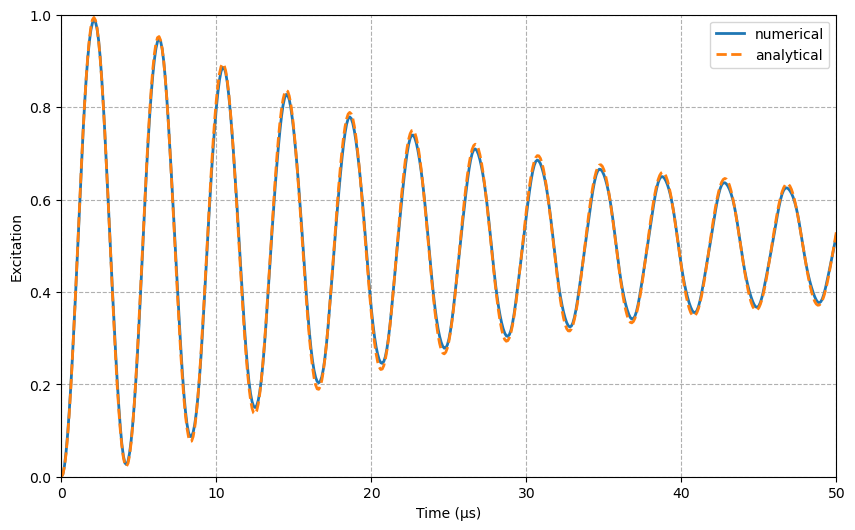

In [22]:
figure(figsize=(10, 6))

ex = expect(ionprojector(T, "e"), sol)
plot(tout, real.(ex), label="numerical", color="C0", linewidth=2)

η = lambdicke(mode, C, L)
plot(
        tout, analytical.rabiflop(tout, 1/4, η, 10), 
        linestyle="--", label="analytical" ,color="C1", linewidth=2 
    )

xlim(tout[1], tout[end])
ylim(0, 1)
legend(loc=1)
ylabel("Excitation")
xlabel("Time (μs)");

grid(true, linestyle="--")
legend()
#show()
display(gcf())

In [15]:
h = hamiltonian(T, timescale=1e-6, lamb_dicke_order=0)  # set lamb_dicke_order here
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

  0.309700 seconds (370.29 k allocations: 332.915 MiB, 10.39% gc time)


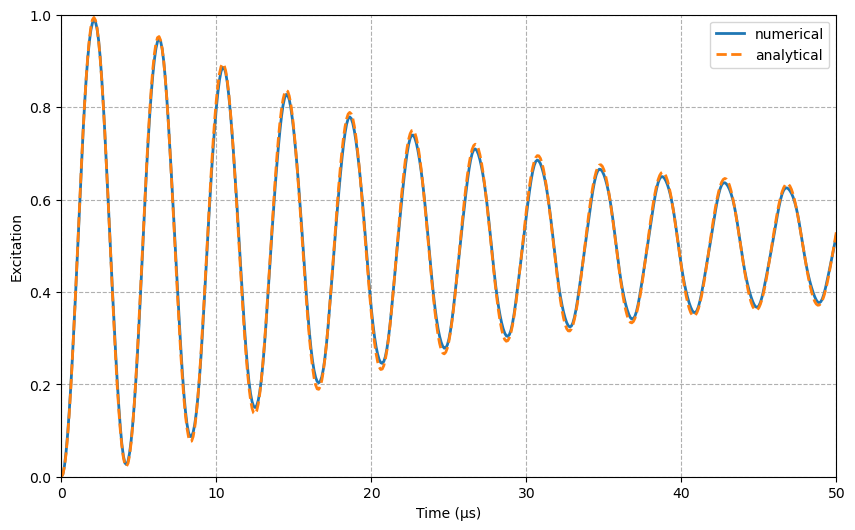

In [25]:
figure(figsize=(10, 6))

ex = expect(ionprojector(T, "e"), sol)
plot(tout, real.(ex), label="numerical", color="C0", linewidth=2)

η = lambdicke(mode, C, L)
plot(
        tout, analytical.rabiflop(tout, 1/4, η, 10), 
        linestyle="--", label="analytical" ,color="C1", linewidth=2 
    )

xlim(tout[1], tout[end])
ylim(0, 1)
legend(loc=1)
ylabel("Excitation")
xlabel("Time (μs)");

grid(true, linestyle="--")
legend()
display(gcf())

In [27]:
function pulse(T:: Chamber , tspan, pitime)
    # Define the laser that will drive the transition
    L = T.lasers[1]

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    
    pi2_time = pitime*1e6/2

    res_intensity = intensity_from_pitime(L, pitime, T.iontrap.ions[1], ("g", "e"), T)

    function intensity_funtion(t)
    if(t<=pi2_time)
        return res_intensity
    elseif(t>=tspan[end] - pi2_time)
        return res_intensity
    else
        return 0.0
    end

    end
    intensity!(L, intensity_funtion)

    function phase_funtion(t)
        if(t<=pi2_time)
            return 2*pi
        elseif(t>=tspan[end] - pi2_time)
            return pi
        else
            return 0.0
        end
    end

    phase!(L, phase_funtion)
    h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);
    return h
end


function experiment(T::Chamber, wait_time)
    pitime = 4e-6
    tspan = 0: 0.1: wait_time+4

    h = pulse(T, tspan, pitime)
    return h
end

# phase!(L, phase_funtion)
# h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);

experiment (generic function with 1 method)

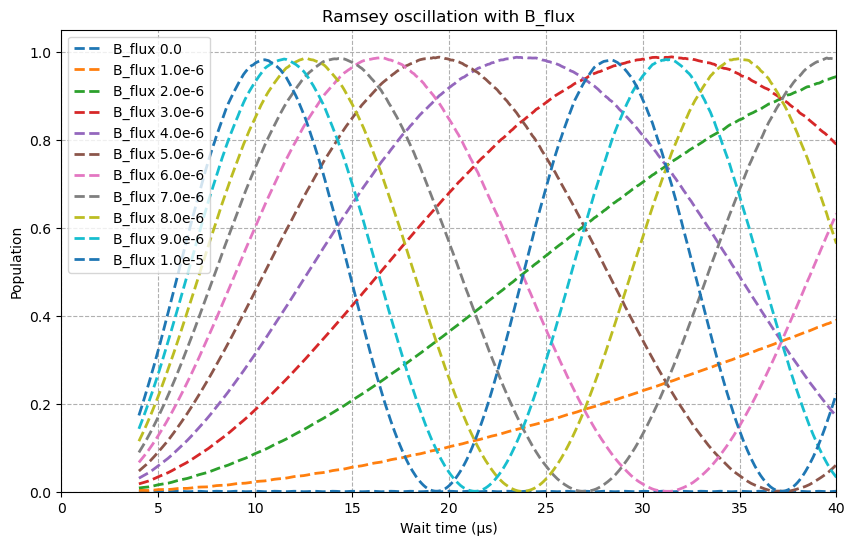

In [ ]:
waittime = 4:0.1:40
B_span = 0:1e-6:1e-5



L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
for delB in B_span

   
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    y1 = Float64[]
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψi, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "e"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
xlim(0, 40)
xlabel("Wait time (μs)")
ylabel("Population")
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()


..0
show()
display(gcf())
